<a href="https://colab.research.google.com/github/romitbarua/Artify/blob/main/TestingNotebooks/PCAvsMFCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#### Articles Used to Generate Code
#https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184
#https://machinelearningmastery.com/face-recognition-using-principal-component-analysis/

In [ ]:
#mount the google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#import appropriate packages
import os
import cv2
import dlib
from google.colab.patches import cv2_imshow
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import librosa
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import itertools

In [ ]:
SYM_PATH = '/content/drive/MyDrive/DeepFakeDetection'
%cd $SYM_PATH
%pip install -e .

/content/drive/MyDrive/DeepFakeDetection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/DeepFakeDetection
  Attempting uninstall: DeepFake
    Found existing installation: DeepFake 0.1.0
    Can't uninstall 'DeepFake'. No files were found to uninstall.
  Running setup.py develop for DeepFake


In [ ]:
#import custom packages
from packages.DlibManager import DlibManager

# Functions

In [ ]:
#function description: normalize the data by centering and dividing by the standard deviation. 

def normalize(data, debug_mode = False):

  if debug_mode:
    print('NORMALIZE DATA')
    print('Data Shape: ', data.shape)
    print('Data Type: ', type(data.dtype))
    print('Mean Shape:', np.mean(data, axis=0).shape)
    print('Std Shape:', np.mean(data, axis=0).shape)
    print('------------------------------')
    
  return (data - np.mean(data, axis=0))/np.std(data, axis=0)

In [ ]:
#function description: for a given array and target value, search within the array and find the index where the array value is closest to the target value

#source: https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest_idx(array, value):
  array = np.asarray(array)
  return (np.abs(array - value)).argmin()
  

In [ ]:
#function description: return objects required for DLIB to generate landmarks

def load_dlib_objects(predictor_path='/content/drive/MyDrive/DeepFakeDetection/model/shape_predictor_68_face_landmarks.dat'):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(predictor_path)
  return detector, predictor

In [ ]:
#function description: 
## There is a misalignment in the number of frames in the MFCCs and video
## The functino below will expand the video frames to match the number of MFCC frame by checking which frame is showing at the center of the MFCC window
## This results in a single video frame being assigned to many MFCC frames

def match_mfcc_dlib(mfccs, dlib_frames, duration, win_time, hop_time, debug_mode=False):

  #convert the window & hop time to seconds (from miliseconds)
  win_time = win_time/1000
  hop_time = hop_time/1000

  #create an array of length: # of MFCC frames. Each value in this array is the time domain representation of the center of the MFCC frame window
  mfcc_times = np.arange(0, mfccs.shape[0], 1)*(hop_time)+0.5*win_time
  
  #create an array of length: # of video frames. Each value in this array is the time domain representation of when each frame starts 
  second_per_frame = duration/len(dlib_frames)
  dlib_frame_times = np.arange(0, len(dlib_frames), 1)*second_per_frame

  #for each MFCC frame, it finds the iamge frame that is currently showing
  new_dlib_frames = [dlib_frames[find_nearest_idx(dlib_frame_times, time)] for time in mfcc_times]
  
  return new_dlib_frames


In [ ]:
#function description: load the video path and return the appropriate attributes from the dlib object

def return_dlib_items(video_path, return_items, detector, predictor, lip_extension, debug_mode=False):

  #the custom dlib object runs a number of calculations such as generating landmarks and cropping lips 
  #these are saved as attributes of the objects
  #since the entire object is large and a pain to lug around, this function will generate the dlib object and return the appropriate items that you want

  assert return_items in ['lips']

  video = cv2.VideoCapture(video_path)
  dlib_video = DlibManager(predictor, detector, video, lip_extension_pixels=lip_extension)
  video.release()

  if debug_mode:
    print('Successfully loaded the Dlib Video')

  if return_items == 'lips':
    if debug_mode:
      print('Returning Lip Frames')
      print('Number of Lip Frames: ', len(dlib_video.lip_frames))
    return dlib_video.lip_frames
  else:
    return -1



In [ ]:
#function description: for a given audio file, generate the mfccs
## if applicable, this function will also calculate the change in MFCCs to a specified order

def return_mfccs(audio_path, sample_rate, window_time, hop_time, mfcc_frames, n_mfcc, delta_order, normalize_mfcc=True, debug_mode=False):

  audio, _ = librosa.load(audio_path, sr=sample_rate)
  audio_duration = librosa.get_duration(audio)

  #calculate the number of frames the window and hop length should be given a length of time for each
  win_length = int(sample_rate/1000 * window_time)
  hop_length = int(sample_rate/1000 * hop_time)

  mfcc = librosa.feature.mfcc(audio, n_mfcc=n_mfcc, win_length=win_length, hop_length=hop_length)

  #calc the change in MFCCs if applicable
  #note that we understand that if we calculate a delta, the mfcc variable is a bit of misnomer - but this makes the rest of the code run cleanly
  if delta_order > 0:
    mfcc = librosa.feature.delta(mfcc, order=delta_order)

  #mfcc is returned as (num coefficients, number of frames)
  #to run predictions on a frame basis, we want the mfcc to be (number of frames, num coefficients)
  mfcc = mfcc.T

  if normalize_mfcc:
    mfcc = normalize(mfcc, debug_mode)

  return mfcc, audio_duration




In [ ]:
#function description: generate a list of the video path, lip frames & mfccs for each video

def load_mfcc_lip_data(id_paths, audio_sample_rate=22050, window_time=25, hop_time=10, n_mfcc=12, delta_order=0, lip_extension=5, debug_mode=False):

  detector, predictor = load_dlib_objects()
  
  video_details = []
  failed_to_load = []

  for idx, id_path in enumerate(id_paths):
    print(f'\rVideo #{idx+1} out of {len(id_paths)}', end="")
    
    video_path = id_path
    audio_path = video_path.replace('.mp4', '.wav')

    #get the lip frames from dlib
    lip_frames = return_dlib_items(video_path, 'lips', detector, predictor, lip_extension=lip_extension, debug_mode=debug_mode)
    #generate the mfccs from the audio
    mfcc, duration = return_mfccs(audio_path, audio_sample_rate, window_time, hop_time, len(lip_frames), n_mfcc=n_mfcc, delta_order=delta_order)
    #align the lip frames to match the number of frames in the mfcc
    lip_frames = match_mfcc_dlib(mfcc, lip_frames, duration, window_time, hop_time)
    video_details.append([video_path, lip_frames, mfcc])


  if debug_mode:
    print('Number of Videos Loaded: ', len(list(video_details.keys())))
  #will return a 2d list of "shape" (number of videos, 3) -> where the 3 include the video path, a list of lip frames & a numpy array of MFCCs
  return video_details


In [ ]:
#function description: take an image and prepare it for PCA
## includes converting the image to gray (if applicable), reshaping to the appropriate dimensions & flattening

def prep_images_for_pca(frames, grey_image=True, height=50, width=70):

  processed_frames = []

  for frame in frames:
    if grey_image:
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.resize(frame, (width, height))

    processed_frames.append(frame)

  num_frames = len(processed_frames)
  processed_frames = np.array(processed_frames).reshape(num_frames, height*width)

  return processed_frames


In [ ]:
#function description: for a given data, return the weights and mean of the data
## If fit is True, then you will generate the PCA object - used for training
## If fit is False, then use the training mean to center the data & generate weights using the training eigenfaces

def run_pca(data, num_components, fit, data_mean=None, pca=None, debug_mode=False):

  assert ((fit == False and not isinstance(data_mean, type(None)) and not isinstance(pca, type(None))) or fit), "Must provide a data_mean if you are reversing"

  if debug_mode:
    print('Running PCA:')
    print('Data Shape: ', data.shape)
    print()

  if fit:
    data_mean = np.mean(data, axis=0)
    data_centered = data - data_mean

    pca = PCA(n_components=num_components)
    pca_data = pca.fit_transform(data_centered)

  else:
    
    data_centered = data - data_mean
    pca_data = pca.transform(data_centered)

  weights = np.dot(data_centered, pca.components_[:num_components].T)

  return pca, weights, data_mean, data_centered

In [ ]:
#function description: this functino takes in lip frames & mfcc to generate the X, y matrix that will be used for training and testing
## Takes the lip frames for processing, runs PCA & then creates the X matrix using the eigenlips weights
## The y matrix is a concatenation of all the MFCC values 

def generate_mfcc_pca_lips_X_y_data(video_details, fit_pca, num_components=10, pca=None, data_mean=None, debug_mode = False):
  
  lips_data = None
  X  = None
  y = None

  if debug_mode:
    print('Generating X & y for the training data:')
    print('Size of Video Details: ', len(video_details))

  for idx, video_data in enumerate(video_details):

    if debug_mode:
      print(f'Running #{idx+1} of {len(video_details)}')
      print('Items to Unpack: ', len(video_details))

    video_path, lip_frames, mfcc = video_data

    if debug_mode:
      print('Number of Lip Frames: ', len(lip_frames))
      print('Shape of Lip 1: ', lip_frames[0].shape)

    pca_ready_lips = prep_images_for_pca(lip_frames)

    if debug_mode:
      print('PCA Processed Lips Shape: ', pca_ready_lips.shape)

    if isinstance(lips_data, type(None)):
      lips_data = pca_ready_lips
      y = mfcc
    else:
      lips_data = np.vstack((lips_data, pca_ready_lips))
      y = np.vstack((y, mfcc))

  if debug_mode:
    print('Shape of Lips Data: ', lips_data.shape)

  video_details = None

  if debug_mode:
    'Starting to Run PCA'

  pca, weights, lips_data_mean, data_centered = run_pca(lips_data, num_components, fit_pca, data_mean, pca, debug_mode=debug_mode)

  X = weights

  return X, y, lips_data_mean, pca, lips_data


In [ ]:
def display_eigenfaces(pca, num_components, width=70, height=60):
  #show the eigenfaces
  eigenfaces = pca.components_[:num_components]
  
  # Show the first 16 eigenfaces
  fig, axes = plt.subplots(2,5,figsize=(16,8))
  idx = 0
  for i in range(5):
    for j in range(2):
      axes[j][i].imshow(eigenfaces[idx].reshape((width, height)), cmap="gray")
      idx += 1
  plt.show()

In [ ]:
def pca_image_reconstruction(pca, centered_image, image_mean, num_components=10, width=70, height=60, image_idx=0):
  
  eigenfaces = pca.components_[:num_components]
  samples, features = centered_image.shape
  weights = np.dot(centered_image, eigenfaces.T)
  recovered_image = (np.dot(weights[image_idx,:], eigenfaces)+image_mean).reshape(width, height)
  return recovered_image



In [ ]:
#function description: given an X & y matrix, this function will train a model for each MFCC
## In this case, we are using the PCA weights to predict each MFCC

def train_models(X, y, model_type='LinearRegression'):

  num_coef = y.shape[1]
  models = []
  for i in range(num_coef):
    assert X.shape[0] == y[:, i].shape[0], 'X and y must have the same number of rows'
    
    if model_type == 'LinearRegression':
      model = LinearRegression()
    elif model_type == 'RandomForest':
      model = RandomForestRegressor()
    model.fit(X, y[:, i])
    models.append(model)

  return models

In [ ]:
#function description: for each video, calculate an average frame error for each of the MFCC prediction
## will return error for each MFCC separately

def eval_test_data(test_video_details, models, data_mean, pca,  num_components, components=None, debug_mode=False):

  #store the average per video mean squared error
  video_error = []

  for idx, video_data in enumerate(test_video_details):

    #if key not in fake_testing_details.keys():
    #  continue

    X_test, y_test, lips_data_mean, pca, lip_data_real = generate_mfcc_pca_lips_X_y_data([video_data], fit_pca=False, data_mean=data_mean, pca=pca, num_components=num_components, debug_mode=debug_mode)

    if not isinstance(components, type(None)):
      X_test = X_test[:, components]

    #store error for each coefficient
    mfcc_errors = []

    if debug_mode:
      print(f'Training Models for Video {idx} out of {len(real_testing_details.keys())}')

    for idx, model in enumerate(models):
      y_pred = model.predict(X_test)

      err = mean_squared_error(y_true=y_test[:, idx], y_pred=y_pred)

      mfcc_errors.append(err)

    video_error.append(mfcc_errors)

  return video_error



In [ ]:
# Function Description: (FOR FUTURE USE - PCA SEARCHING)

def generate_test_data_mfcc_search(real_testing_details, fake_testing_details, data_mean, pca, num_components=15, components=None, debug_mode=False):

  #store the average per video mean squared error

  X_test_real = None
  X_test_fake = None
  y_test_real = None
  y_test_fake = None
  real_test_ids = []
  fake_test_ids = []

  for idx, key in enumerate(real_testing_details.keys()):

    if key not in fake_testing_details.keys():
      continue

    video_X_test_real, video_y_test_real, lips_data_mean, pca, lip_data_real = generate_mfcc_pca_lips_X_y_data({key:real_testing_details[key]}, fit_pca=False, data_mean=data_mean, pca=pca, num_components=num_components, debug_mode=debug_mode)
    video_X_test_fake, video_y_test_fake, lips_data_mean, pca, lip_data_fake = generate_mfcc_pca_lips_X_y_data({key:fake_testing_details[key]}, fit_pca=False, data_mean=data_mean, pca=pca, num_components=num_components, debug_mode=debug_mode)

    if isinstance(X_test_real, type(None)):
      
      X_test_real = video_X_test_real
      X_test_fake = video_X_test_fake
      y_test_real = video_y_test_real
      y_test_fake = video_y_test_fake

    else:

      X_test_real = np.vstack((X_test_real, video_X_test_real))
      X_test_fake = np.vstack((X_test_fake, video_X_test_fake))
      y_test_real = np.vstack((y_test_real, video_y_test_real))
      y_test_fake = np.vstack((y_test_fake, video_y_test_fake))

    real_test_ids.extend([key]*video_X_test_real.shape[0])
    fake_test_ids.extend([key]*video_X_test_fake.shape[0])

    return X_test_real, X_test_fake, y_test_real, y_test_fake, real_test_ids, fake_test_ids


In [ ]:
# Function Description: (FOR FUTURE USE - PCA SEARCHING)

def eval_test_mfcc_search(X_test_real, X_test_fake, y_test_real, y_test_fake, models):

  #store the per frame error
  real_mfcc_errors = []
  fake_mfcc_errors = []

  for idx, model in enumerate(models):
    y_pred_real = model.predict(X_test_real)
    y_pred_fake = model.predict(X_test_fake)

    real_err = mean_squared_error(y_true=y_test_real[:, idx], y_pred=y_pred_real)
    fake_err = mean_squared_error(y_true=y_test_fake[:, idx], y_pred=y_pred_fake)

    real_mfcc_errors.append(real_err)
    fake_mfcc_errors.append(fake_err)

  return real_mfcc_errors, fake_mfcc_errors

In [ ]:
#function description: takes in the real & fake video MFCC errors and plots
## each MFCC gets its own plot

def plot_mfcc_error_dist(real_video_error, fake_video_error):

  real_video_error = np.array(real_video_error)
  fake_video_error = np.array(fake_video_error)

  fig, axes = plt.subplots(6,2,figsize=(20,22))
  idx = 0

  for i in range(6):
    for j in range(2):
      sns.kdeplot(real_video_error[:, idx], ax=axes[i, j])
      sns.kdeplot(fake_video_error[:, idx], ax=axes[i,j])
      axes[i, j].set_title(f'MFCC {idx+1}')
      idx += 1

  plt.legend()
  plt.show()

  #sns.kdeplot(real_video_error, label='Real', color='red')
  #sns.kdeplot(fake_video_error, label='Fake', color='blue')
  #plt.legend(ax[])
  #plt.show()


# Experiments

In [ ]:
#load and clean the FakeAVCeleb metadata file
#fakeAV_metadata = pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/meta_data.csv')
#fakeAV_metadata = fakeAV_metadata[(fakeAV_metadata['method']=='real') | (fakeAV_metadata['method']=='wav2lip')]
#fakeAV_metadata = fakeAV_metadata.rename(columns={'Unnamed: 9':'full_path'})
#fakeAV_metadata['full_path'] = fakeAV_metadata['full_path'].str.replace('FakeAVCeleb/', '/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/')
#fakeAV_metadata['full_path'] = fakeAV_metadata['full_path'] + '/' + fakeAV_metadata['path']

#fakeAV_real = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/real_mp4_fav_paths.csv').columns)
#fakeAV_fake = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/fake_mp4_fav_paths.csv').columns)


In [ ]:
#set global assumptions
num_pca_components = 15
num_mfcc_coefficients = 12
percent_train = 0.8

## Experiment #1: General - All Training Videos

To test how the PCA vs. MFCC feature would generalize to the entire population, we included all race & genders. 


### Run #1 - MFCC Delta 0

In [ ]:
fakeAV_real = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/real_mp4_fav_paths.csv').columns)[:50]
fakeAV_fake = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/fake_mp4_fav_paths.csv').columns)


#assign run level assumptions
mfcc_delta_order = 0

In [2]:
#generate the training & testing ids
training_ids = np.random.choice(fakeAV_real, int(fakeAV_real.shape[0]*percent_train), replace=False)
testing_ids_real = fakeAV_real[np.isin(fakeAV_real, training_ids, invert=True)]
testing_ids_fake = np.random.choice(fakeAV_fake, testing_ids_real.shape[0], replace=False)

#get the training details
print('\nLoading Training Details')
training_details = load_mfcc_lip_data(training_ids, delta_order=mfcc_delta_order, debug_mode=False)

#run PCA & generate X & Y
print('\nRunning PCA & Generating Training X & y')
X_train, y_train, lips_data_mean, pca, train_lips_data = generate_mfcc_pca_lips_X_y_data(training_details, True, debug_mode=False)

#fit training models
print('\nFitting Models')
models = train_models(X_train, y_train, 'LinearRegression')

#get testing details (1 real video, 1 fake video)
print('\nLoading Real Testing Details')
real_testing_details = load_mfcc_lip_data(testing_ids_real, delta_order=mfcc_delta_order, debug_mode=False)
print('\nLoading Fake Testing Details')
fake_testing_details = load_mfcc_lip_data(testing_ids_fake, delta_order=mfcc_delta_order, debug_mode=False)

# evaluate testing
print('\nEvaluating Testing Details')
real_video_error = eval_test_data(test_video_details=real_testing_details, models=models, data_mean=lips_data_mean, pca=pca, num_components=num_pca_components, debug_mode=False)
fake_video_error = eval_test_data(test_video_details=fake_testing_details, models=models, data_mean=lips_data_mean, pca=pca, num_components=num_pca_components, debug_mode=False)

print('\nPlotting Coefficients')
plot_mfcc_error_dist(real_video_error, fake_video_error)

NameError: ignored

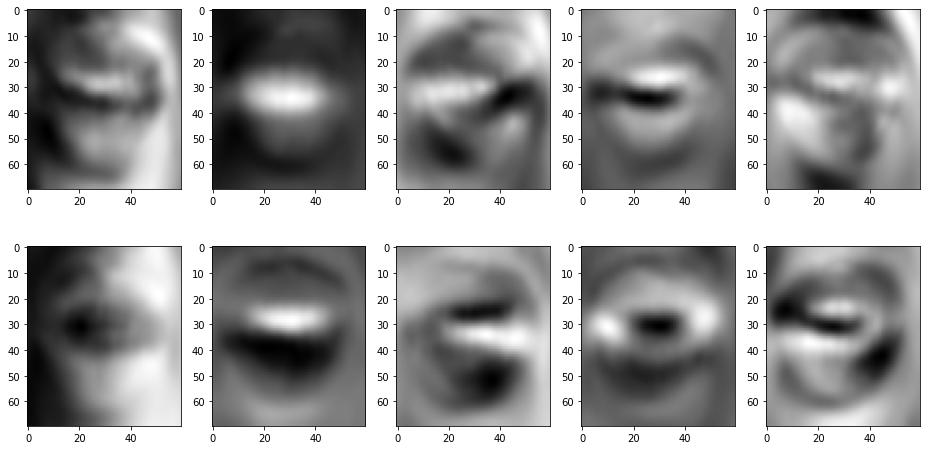

In [ ]:
display_eigenfaces(pca, 10)

In [ ]:
#random_training_ids = np.random.choice(np.array(list(training_details.keys())),5, replace=False)
#random_lips = []
#for training_id in random_training_ids:
#  rand_idx = np.random.choice(np.arange(0, len(training_details[training_id][1])))
#  image = training_details[training_id][1][rand_idx]
#  random_lips.append(image)

In [ ]:
'''pca_ready_images = prep_images_for_pca(random_lips)
reconstruction_pca, reconstruction_weights, reconstruction_data_mean, reconstruction_data_centered = run_pca(pca_ready_images, 10, False, lips_data_mean, pca)

reconstructed_images = [pca_image_reconstruction(reconstruction_pca, reconstruction_data_centered, reconstruction_data_mean, num_components=5, width=70, height=90, image_idx=i) for i in range(5)]

fig, axes = plt.subplots(2,5,figsize=(16,8))
for i in range(5):
    axes[0][i].imshow(random_lips[i])
    axes[1][i].imshow(reconstructed_images[i].reshape((70, 90)), cmap="gray")
plt.show()'''

'pca_ready_images = prep_images_for_pca(random_lips)\nreconstruction_pca, reconstruction_weights, reconstruction_data_mean, reconstruction_data_centered = run_pca(pca_ready_images, 10, False, lips_data_mean, pca)\n\nreconstructed_images = [pca_image_reconstruction(reconstruction_pca, reconstruction_data_centered, reconstruction_data_mean, num_components=5, width=70, height=90, image_idx=i) for i in range(5)]\n\nfig, axes = plt.subplots(2,5,figsize=(16,8))\nfor i in range(5):\n    axes[0][i].imshow(random_lips[i])\n    axes[1][i].imshow(reconstructed_images[i].reshape((70, 90)), cmap="gray")\nplt.show()'

### Run #2 - MFCC Delta 1

In [ ]:
fakeAV_real = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/real_mp4_fav_paths.csv').columns)[:20]
fakeAV_fake = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/fake_mp4_fav_paths.csv').columns)

#experiment-specific assumptions
mfcc_delta_order=1

In [ ]:
#generate the training & testing ids
training_ids = np.random.choice(fakeAV_real, int(fakeAV_real.shape[0]*percent_train), replace=False)
testing_ids_real = fakeAV_real[np.isin(fakeAV_real, training_ids, invert=True)]
testing_ids_fake = np.random.choice(fakeAV_fake, testing_ids_real.shape[0], replace=False)

#get the training details
print('\nLoading Training Details')
training_details = load_mfcc_lip_data(training_ids, delta_order=mfcc_delta_order, debug_mode=False)

#run PCA & generate X & Y
print('\nRunning PCA & Generating Training X & y')
X_train, y_train, lips_data_mean, pca, train_lips_data = generate_mfcc_pca_lips_X_y_data(training_details, True, debug_mode=False)

#fit training models
print('\nFitting Models')
models = train_models(X_train, y_train, 'LinearRegression')

#get testing details (1 real video, 1 fake video)
print('\nLoading Real Testing Details')
real_testing_details = load_mfcc_lip_data(testing_ids_real, delta_order=mfcc_delta_order, debug_mode=False)
print('\nLoading Fake Testing Details')
fake_testing_details = load_mfcc_lip_data(testing_ids_fake, delta_order=mfcc_delta_order, debug_mode=False)

# evaluate testing
print('\nEvaluating Testing Details')
real_video_error = eval_test_data(test_video_details=real_testing_details, models=models, data_mean=lips_data_mean, pca=pca, num_components=num_pca_components, debug_mode=False)
fake_video_error = eval_test_data(test_video_details=fake_testing_details, models=models, data_mean=lips_data_mean, pca=pca, num_components=num_pca_components, debug_mode=False)

plot_mfcc_error_dist(real_video_error, fake_video_error)


Loading Training Details
Video #341 out of 341
Running PCA & Generating Training X & y


## Experiment #2: Subgroup - Race=African, Gender=Male

### Run #1 - MFCC Delta 0

In [ ]:
fakeAV_real = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/real_mp4_fav_paths.csv').columns)
fakeAV_fake = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/fake_mp4_fav_paths.csv').columns)

fakeAV_real = np.array([path for path in fakeAV_real if ('/African/' in path and '/men/' in path)])
fakeAV_fake = np.array([path for path in fakeAV_fake if ('/African/' in path and '/men/' in path)])

#experiment-specific assumptions
mfcc_delta_order=0


Loading Training Details
Video #30 out of 30
Running PCA & Generating Training X & y

Fitting Models

Loading Real Testing Details
Video #8 out of 8
Loading Fake Testing Details
Video #8 out of 8
Evaluating Testing Details


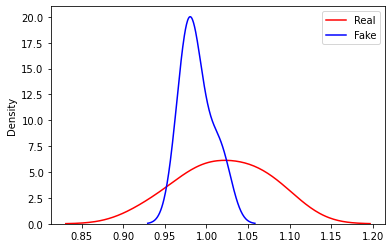

In [ ]:
#generate the training & testing ids
training_ids = np.random.choice(fakeAV_real, int(fakeAV_real.shape[0]*percent_train), replace=False)
testing_ids_real = fakeAV_real[np.isin(fakeAV_real, training_ids, invert=True)]
testing_ids_fake = np.random.choice(fakeAV_fake, testing_ids_real.shape[0], replace=False)

#get the training details
print('\nLoading Training Details')
training_details = load_mfcc_lip_data(training_ids, delta_order=mfcc_delta_order, debug_mode=False)

#run PCA & generate X & Y
print('\nRunning PCA & Generating Training X & y')
X_train, y_train, lips_data_mean, pca, train_lips_data = generate_mfcc_pca_lips_X_y_data(training_details, True, debug_mode=False)

#fit training models
print('\nFitting Models')
models = train_models(X_train, y_train, 'LinearRegression')

#get testing details (1 real video, 1 fake video)
print('\nLoading Real Testing Details')
real_testing_details = load_mfcc_lip_data(testing_ids_real, delta_order=mfcc_delta_order, debug_mode=False)
print('\nLoading Fake Testing Details')
fake_testing_details = load_mfcc_lip_data(testing_ids_fake, delta_order=mfcc_delta_order, debug_mode=False)

# evaluate testing
print('\nEvaluating Testing Details')
real_video_error = eval_test_data(test_video_details=real_testing_details, models=models, data_mean=lips_data_mean, pca=pca, num_components=num_pca_components, debug_mode=False)
fake_video_error = eval_test_data(test_video_details=fake_testing_details, models=models, data_mean=lips_data_mean, pca=pca, num_components=num_pca_components, debug_mode=False)

plot_mfcc_error_dist(real_video_error, fake_video_error)

### Run #2 - MFCC Delta 1

In [ ]:
fakeAV_real = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/real_mp4_fav_paths.csv').columns)
fakeAV_fake = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/fake_mp4_fav_paths.csv').columns)

fakeAV_real = np.array([path for path in fakeAV_real if ('/African/' in path and '/men/' in path)])
fakeAV_fake = np.array([path for path in fakeAV_fake if ('/African/' in path and '/men/' in path)])

#experiment-specific assumptions
mfcc_delta_order=1


Loading Training Details
Video #30 out of 30
Running PCA & Generating Training X & y

Fitting Models

Loading Real Testing Details
Video #8 out of 8
Loading Fake Testing Details
Video #8 out of 8
Evaluating Testing Details


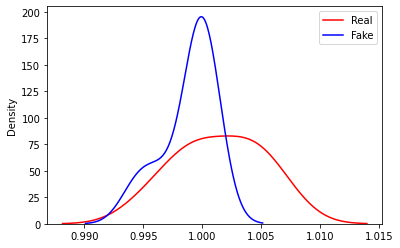

In [ ]:
#generate the training & testing ids
training_ids = np.random.choice(fakeAV_real, int(fakeAV_real.shape[0]*percent_train), replace=False)
testing_ids_real = fakeAV_real[np.isin(fakeAV_real, training_ids, invert=True)]
testing_ids_fake = np.random.choice(fakeAV_fake, testing_ids_real.shape[0], replace=False)

#get the training details
print('\nLoading Training Details')
training_details = load_mfcc_lip_data(training_ids, delta_order=mfcc_delta_order, debug_mode=False)

#run PCA & generate X & Y
print('\nRunning PCA & Generating Training X & y')
X_train, y_train, lips_data_mean, pca, train_lips_data = generate_mfcc_pca_lips_X_y_data(training_details, True, debug_mode=False)

#fit training models
print('\nFitting Models')
models = train_models(X_train, y_train, 'LinearRegression')

#get testing details (1 real video, 1 fake video)
print('\nLoading Real Testing Details')
real_testing_details = load_mfcc_lip_data(testing_ids_real, delta_order=mfcc_delta_order, debug_mode=False)
print('\nLoading Fake Testing Details')
fake_testing_details = load_mfcc_lip_data(testing_ids_fake, delta_order=mfcc_delta_order, debug_mode=False)

# evaluate testing
print('\nEvaluating Testing Details')
real_video_error = eval_test_data(test_video_details=real_testing_details, models=models, data_mean=lips_data_mean, pca=pca, num_components=num_pca_components, debug_mode=False)
fake_video_error = eval_test_data(test_video_details=fake_testing_details, models=models, data_mean=lips_data_mean, pca=pca, num_components=num_pca_components, debug_mode=False)

plot_mfcc_error_dist(real_video_error, fake_video_error)

## Experiment #3 - Single Subject

### Run #1: ID - 01610, MFCC Delta=0

In [ ]:
#assign run level assumptions
mfcc_delta_order = 0
id = 'id01610'

#load the metadata
subject_real_metadata = np.array(pd.read_csv(f'/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/{id}_real.csv').columns)
subject_fake_metadata = pd.read_csv(f'/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/{id}_fake.csv').columns
subject_fake_metadata = np.array([link for link in subject_fake_metadata if 'RealVideo-RealAudio' not in link]) #remove the real video in the fake metadata


In [1]:
#generate the training & testing ids
testing_ids_fake = subject_fake_metadata
testing_ids_real = np.random.choice(subject_real_metadata, testing_ids_fake.shape[0], replace=False)
training_ids = subject_real_metadata[np.isin(subject_real_metadata, testing_ids_real, invert=True)]

#get the training details
print('\nLoading Training Details')
training_details = load_mfcc_lip_data(training_ids, delta_order=mfcc_delta_order, debug_mode=False)

#run PCA & generate X & Y
print('\nRunning PCA & Generating Training X & y')
X_train, y_train, lips_data_mean, pca, train_lips_data = generate_mfcc_pca_lips_X_y_data(training_details, True, num_components=num_pca_components, debug_mode=False)

#fit training models
print('\nFitting Models')
models = train_models(X_train, y_train, 'LinearRegression')

#get testing details (1 real video, 1 fake video)
print('\nLoading Real Testing Details')
real_testing_details = load_mfcc_lip_data(testing_ids_real, delta_order=mfcc_delta_order, debug_mode=False)
print('\nLoading Fake Testing Details')
fake_testing_details = load_mfcc_lip_data(testing_ids_fake, delta_order=mfcc_delta_order, debug_mode=False)

# evaluate testing
print('\nEvaluating Testing Details')
real_video_error = eval_test_data(test_video_details=real_testing_details, models=models, data_mean=lips_data_mean, pca=pca, num_components=num_pca_components, debug_mode=False)
fake_video_error = eval_test_data(test_video_details=fake_testing_details, models=models, data_mean=lips_data_mean, pca=pca, num_components=num_pca_components, debug_mode=False)

plot_mfcc_error_dist(real_video_error, fake_video_error)


NameError: ignored

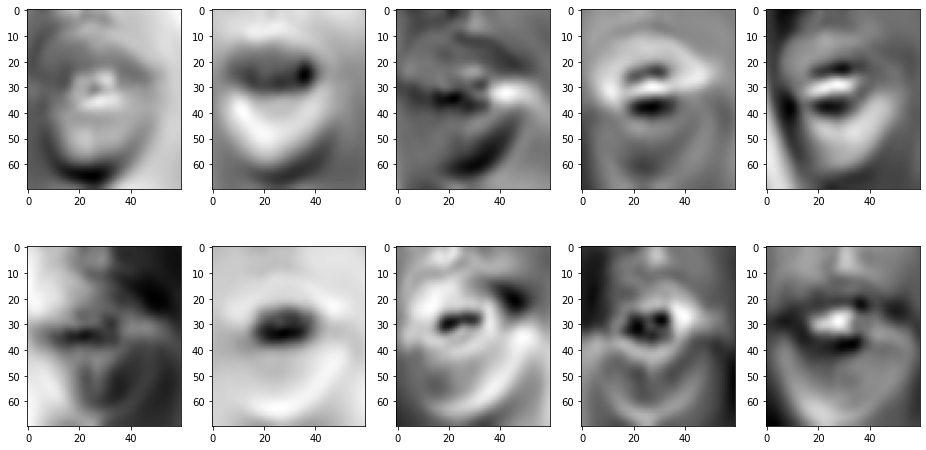

In [ ]:
display_eigenfaces(pca, 10)

### Run #2: ID - 01163, MFCC Delta=0

In [ ]:
#assign run level assumptions
mfcc_delta_order = 0
id = 'id01163'

#load the metadata
subject_real_metadata = np.array(pd.read_csv(f'/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/{id}_real.csv').columns)
subject_fake_metadata = pd.read_csv(f'/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/{id}_fake.csv').columns
subject_fake_metadata = np.array([link for link in subject_fake_metadata if 'RealVideo-RealAudio' not in link]) #remove the real video in the fake metadata


In [ ]:
#generate the training & testing ids
testing_ids_fake = subject_fake_metadata
testing_ids_real = np.random.choice(subject_real_metadata, testing_ids_fake.shape[0], replace=False)
training_ids = subject_real_metadata[np.isin(subject_real_metadata, testing_ids_real, invert=True)]

#get the training details
print('\nLoading Training Details')
training_details = load_mfcc_lip_data(training_ids, delta_order=mfcc_delta_order, debug_mode=False)

#run PCA & generate X & Y
print('\nRunning PCA & Generating Training X & y')
X_train, y_train, lips_data_mean, pca, train_lips_data = generate_mfcc_pca_lips_X_y_data(training_details, True, num_components=num_pca_components, debug_mode=False)

#fit training models
print('\nFitting Models')
models = train_models(X_train, y_train, 'LinearRegression')

#get testing details (1 real video, 1 fake video)
print('\nLoading Real Testing Details')
real_testing_details = load_mfcc_lip_data(testing_ids_real, delta_order=mfcc_delta_order, debug_mode=False)
print('\nLoading Fake Testing Details')
fake_testing_details = load_mfcc_lip_data(testing_ids_fake, delta_order=mfcc_delta_order, debug_mode=False)

# evaluate testing
print('\nEvaluating Testing Details')
real_video_error = eval_test_data(test_video_details=real_testing_details, models=models, data_mean=lips_data_mean, pca=pca, num_components=num_pca_components, debug_mode=False)
fake_video_error = eval_test_data(test_video_details=fake_testing_details, models=models, data_mean=lips_data_mean, pca=pca, num_components=num_pca_components, debug_mode=False)

plot_mfcc_error_dist(real_video_error, fake_video_error)


## PCA & MFCC Search

In [ ]:
'''
#source: https://stackoverflow.com/questions/464864/how-to-get-all-possible-combinations-of-a-list-s-elements
#get all possible combinations of pca components
weight_combs = []
weight_idx = list(np.arange(0, 15, 1))
for L in range(len(weight_idx) + 1):
    for subset in itertools.combinations(weight_idx, L):
        weight_combs.append(subset)
'''

In [ ]:
'''
#load the metadata
metadata = pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/meta_data.csv')
metadata = metadata[(metadata['method']=='real') | (metadata['method']=='wav2lip')]
metadata = metadata.rename(columns={'Unnamed: 9':'full_path'})
metadata['full_path'] = metadata['full_path'].str.replace('FakeAVCeleb/', '/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/')
metadata['full_path'] = metadata['full_path'] + '/' + metadata['path']
metadata = metadata[(metadata['gender']=='men') & (metadata['race']=='African')]

#generate the training & testing ids
training_ids = np.random.choice(metadata.source.unique(), int(metadata.source.unique().shape[0]*0.8), replace=False)
testing_ids = np.array(metadata[~metadata['source'].isin(training_ids)]['source'].unique())

#get the training details
print('\nLoading Training Details')
training_details = load_FakeAvCeleb_mfcc_lip_data(metadata, training_ids, 'real', debug_mode=False)

#run PCA & generate X & Y
print('\nRunning PCA & Generating Training X & y')
X_train, y_train, lips_data_mean, pca, train_lips_data = generate_mfcc_pca_lips_X_y_data(training_details, True, num_components=15, debug_mode=False)

#fit training models
print('\nFitting Models')
model_versions = []
for idx, weight_comb in enumerate(weight_combs[1:]):
  print(f'Model {idx+1} of {len(weight_combs[1:])}')
  models = train_models(X_train[:, weight_comb], y_train, 'LinearRegression')
  model_versions.append(models)

#get testing details (1 real video, 1 fake video)
print('\nLoading Real Testing Details')
real_testing_details = load_FakeAvCeleb_mfcc_lip_data(metadata, testing_ids, 'real', debug_mode=False)
print('\nLoading Fake Testing Details')
fake_testing_details = load_FakeAvCeleb_mfcc_lip_data(metadata, testing_ids, 'wav2lip', sample=True, debug_mode=False)

#sns.histplot(fake_video_error, label='Fake', color='blue')
#sns.histplot(real_video_error, label='Real', color='red')
#plt.legend()
#plt.show()
'''

In [ ]:
'''
# evaluate testing
print('\nEvaluating Testing Details')
error_log_real = []
error_log_fake = []
for idx, models in enumerate(model_versions):
  print(f'Evaluating Model {idx+1} of {len(model_versions)}')
  real_video_error, fake_video_error = eval_test_data(real_testing_details, fake_testing_details, models, lips_data_mean, pca, components=weight_combs[idx+1], debug_mode=False)
  error_log_real.append(real_video_error)
  error_log_fake.append(fake_video_error)
'''


In [ ]:
'''
def evaluate(X_test, y_):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)

  model = LinearRegression()
  model.fit(X_train, y_train)

  pred = model.predict(X_test)
  err = np.sqrt(mean_squared_error(y_true=y_test, y_pred=pred))/len(pred)

  return pred, err
'''


In [ ]:
'''import itertools
comb = []
stuff = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for L in range(len(stuff) + 1):
    for subset in itertools.combinations(stuff, L):
        comb.append(subset)
'''

In [ ]:
#len(comb)*20